<h1>1. testing out sentence transformer...

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

sents = ['hi there my name is philip', 'salutations, i\'m called philip']

embeddings = model.encode(sents)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embeddings.shape, type(embeddings[1])

((2, 384), numpy.ndarray)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(embeddings[0].reshape(1,-1), embeddings[1].reshape(1,-1))

cos_sim

array([[0.71518713]], dtype=float32)

In [ ]:
docs = fetch_20newsgroups(subset='all', remove=('headers', 'foorters', 'quotes'))['data']

In [ ]:
len(docs)

18846

In [ ]:
embeddings = model.encode(docs[:100])
embeddings.shape

(100, 384)

In [ ]:
sim = model.similarity(embeddings, embeddings)
sim.shape, sim

(torch.Size([100, 100]),
 tensor([[ 1.0000,  0.0196,  0.1641,  ...,  0.1600,  0.1096,  0.0022],
         [ 0.0196,  1.0000,  0.1367,  ...,  0.0716, -0.0469,  0.0827],
         [ 0.1641,  0.1367,  1.0000,  ..., -0.0964,  0.1053,  0.0524],
         ...,
         [ 0.1600,  0.0716, -0.0964,  ...,  1.0000,  0.0162,  0.0104],
         [ 0.1096, -0.0469,  0.1053,  ...,  0.0162,  1.0000,  0.0533],
         [ 0.0022,  0.0827,  0.0524,  ...,  0.0104,  0.0533,  1.0000]]))

In [ ]:
reduced_embeddings.shape

(100, 2)

<h1>2. testing out dimensionality reduction using pca or hdbscan...

In [ ]:
#dimensionality reduction using pca
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
embeddings.shape

(100, 384)

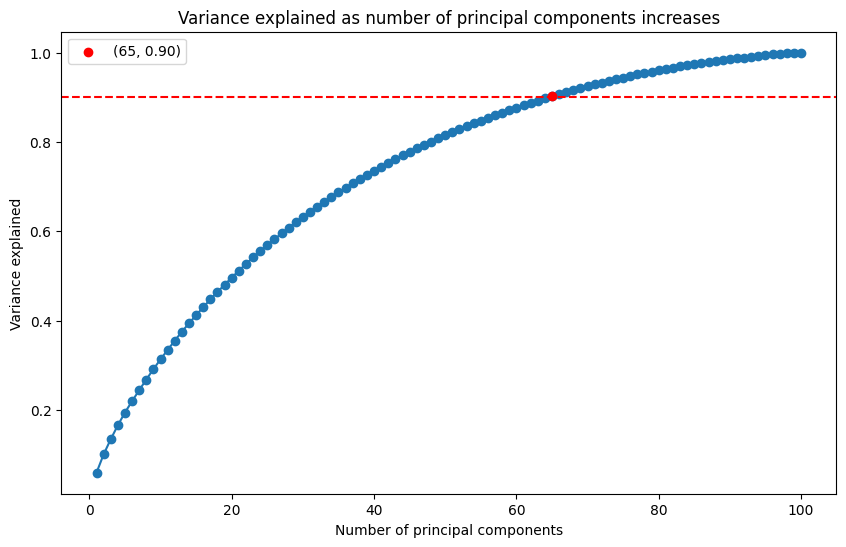

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pca.fit(embeddings)
eigen_vals = pca.explained_variance_
cum_var = np.cumsum(eigen_vals)/np.sum(eigen_vals)
x_index = np.argmax(cum_var >= 0.9)
y_val = cum_var[x_index]

plt.figure(figsize=(10,6))
plt.plot(range(1,len(eigen_vals)+1), cum_var, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.xlabel('Number of principal components')
plt.ylabel('Variance explained')
plt.title('Variance explained as number of principal components increases')

plt.scatter(y=y_val, x=x_index+1, color='red', zorder=3, label=f'({x_index + 1}, {y_val:.2f})') #need to do x_index+1 because the
plt.legend()

In [ ]:
pca_66 = PCA(n_components=66)
reduced_embeddings = pca_66.fit_transform(embeddings)
reduced_embeddings.shape

(100, 66)

Text(0, 0.5, 'dim_2')

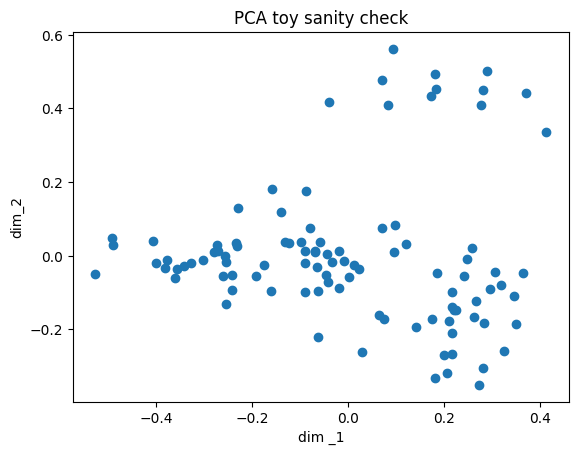

In [ ]:
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1])
plt.title('PCA toy sanity check')
plt.xlabel('dim _1')
plt.ylabel('dim_2')

In [ ]:
#cluster analysis
import hdbscan

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
clusterer.fit(reduced_embeddings[:,:2])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN(gen_min_span_tree=True, min_cluster_size=15)

<Axes: >

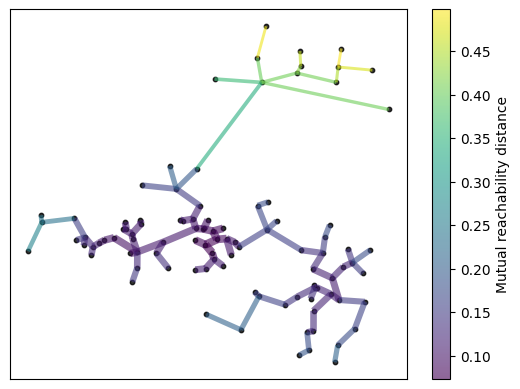

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=10,
                                      edge_linewidth=2)

how hdbscan works
- consider lower density points as the 'sea'
- mutual reachability distance as the distance metric between points
- mrd between points is max(dist_between_a_b, core_dist_a, cord_dist_b), where core_dist is the radius of circle to create cluster of min_num points
- higher mrd means more sparse and further apart
- min_cluster_size as the min num points to create a cluster (constitutes the core distance)
- mrd as the distance metric
- based on mrd, build a minimum spanning tree
- recall that mst is the <b>subset of edges of a connected, edge-weighted undirected graph that connects all vertices together without any cycles and with the minimum possible total edge weight</b>

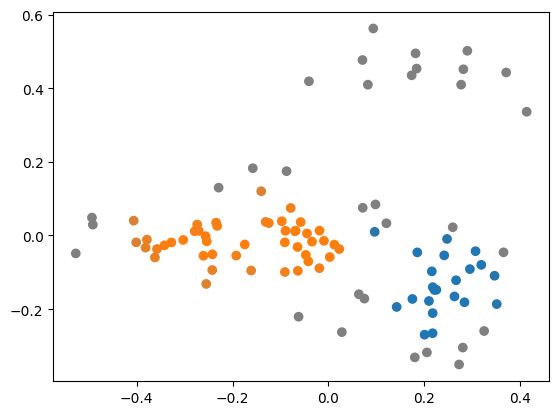

In [ ]:
import seaborn as sns

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=cluster_colors)

In [ ]:
clusterer.labels_

array([-1,  1, -1,  1,  1,  1,  1, -1, -1,  0, -1,  0,  0,  1, -1, -1,  1,
       -1,  0,  1,  1,  1,  1,  1, -1,  1,  0,  1, -1,  0,  1,  0,  1, -1,
        1,  1,  1,  0, -1,  0,  1,  1,  0,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  0, -1,  1, -1,  0,  1,  0,  1, -1,  1,  1,  1, -1, -1, -1,  0,
        1,  1,  1,  0,  1,  1,  0, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,
        0,  0,  0, -1,  0, -1,  0,  0, -1, -1,  1,  1, -1, -1,  1])

In [ ]:
clusterer.probabilities_.shape

(100,)

In [ ]:
#tokenize topics to get topic representation
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")

In [ ]:
X = vectorizer_model.fit_transform(docs[:100])
vectorizer_model.get_feature_names_out()[4000:4010]

array(['soccer', 'social', 'socialist', 'society', 'socket', 'sockets',
       'sod', 'soda', 'soft', 'softimage'], dtype=object)

In [ ]:
X.toarray().shape

(100, 4717)

In [ ]:
doc_clusters = create_doc_clusters(docs[:100], clusterer.labels_)
type(doc_clusters[-1]) #doc_clusters value is a list of str, with each str being  a doc

list

In [ ]:
word_freq_mats = {}
vocabs = {}
word_to_id_dicts = {}
id_to_word_dicts = {}

for key, value in doc_clusters.items():
  word_freq_mat, vocab, word_to_id, id_to_word = create_vocab(value)
  word_freq_mats[key] = word_freq_mat
  vocabs[key] = vocab
  word_to_id_dicts[key] = word_to_id
  id_to_word_dicts[key] = id_to_word

In [ ]:
#sanity check
for key, val in vocabs.items():
  print(key, word_freq_mats[key].shape)
  print(key, len(val))
  print(key, len(word_to_id_dicts[key]))
  print(key, len(id_to_word_dicts[key]))

#need to create word_to_id and id_to_word dicts

-1 (32, 2024)
-1 2024
-1 2024
-1 2024
0 (22, 1762)
0 1762
0 1762
0 1762
1 (46, 1889)
1 1889
1 1889
1 1889


In [ ]:
top_100_words = [id_to_word_dicts[-1][token_id] for token_id in top_100_token_ids]

In [ ]:
top_100_words

['1062',
 '1221',
 '132',
 '07748',
 '13',
 '0362',
 '1040',
 '01',
 '1326',
 '1353',
 '1369',
 '14',
 '139',
 '1267',
 '124',
 '1232',
 '1239',
 '1229',
 '1219',
 '1212',
 '1210',
 '1201',
 '120',
 '12',
 '135',
 '1281',
 '1280x1024x256',
 '1280x1024',
 '1410',
 '11530',
 '1170',
 '1174',
 '1190',
 '1192',
 '1130',
 '1122',
 '1126',
 '11',
 '10th',
 '108',
 '1099',
 '111s',
 '1107',
 '1103',
 '1121',
 '1046',
 '1049',
 '1052',
 '1069',
 '1018',
 '1036',
 '1021',
 '102',
 '10',
 '100',
 '1006',
 '02238',
 '0111',
 '0002',
 '000',
 '00']

In [ ]:
word_freq_mats, vocabs, word_to_id_dict, id_to_word_dict = {},{},{},{}
for idx, para in enumerate(paras):
  key = f'para_{idx+1}'
  print(key, end=' ')
  word_freq_mats[key], vocabs[key], word_to_id_dict[key], id_to_word_dict[key] = create_vocab(para)
  print('done')

para_1 done
para_2 done
para_3 done
para_4 done
para_5 done
para_6 done
para_7 done
para_8 done
para_9 done
para_10 done


In [ ]:
for idx, para in enumerate(paras):
  key = f'para_{idx+1}'
  print(key)
  token_ids, words = tfidf_selection(5, word_freq_mats[key], id_to_word_dict[key])
  print(words)
  print()

para_1
['information', 'privacy', 'society', 'value', 'moral']

para_2
['agency', 'ai', 'action', 'responsibility', 'outcomes']

para_3
['matrix', 'document', 'represents', 'sparse', 'word']

para_4
['moral', 'right', 'value', 'interests', 'privacy']

para_5
['responsibility', 'causal', 'legal', 'proximate', 'moral']

para_6
['responsibility', 'legal', 'state', 'object', 'space']

para_7
['responsible', 'agents', 'ai', 'agency', 'systems']

para_8
['action', 'free', 'execute', 'intentional', 'agent']

para_9
['sort', 'algorithms', 'sorting', 'notes', 'indirect']

para_10
['fields', 'specified', 'option', 'mergesort', 'stable']



<h1>3. this is the important part</h1>
integrated (i) sentence_transformer embeddings, (ii) dimensionality reduction using opt pca, (iii) clustering with hdb scan (using min_points=2), (iv) tfidf selection to generate topic representation

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

In [ ]:
batch_1 = []
for i in range(1,8):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      batch_1.append(line)

batch_2 = []
for i in range(7,15):
  with open(f'day{i}_pages1_3.txt', 'r') as text_file:
    for line in text_file:
      batch_2.append(line)

len(batch_1), len(batch_2)

(669, 720)

In [ ]:
#option 1: use hkunlp/instructor-base, this seems to be the best so far, took 8min for 250 articles for the base, took 24min for large
model = SentenceTransformer("hkunlp/instructor-base")
sentences = [["Generate an embedding that reflects the key themes in this text that can be comparable across embeddings", para] for para in paras]
para_embeddings = model.encode(sentences, show_progress_bar=True)
para_embeddings.shape

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

(669, 768)

In [ ]:
option_1_embedding = para_embeddings
option_1_embedding.shape

(669, 768)

In [ ]:
para_embeddings = option_1_embedding
para_embeddings.shape

(669, 768)

In [ ]:
#option2: use intfloat
model = SentenceTransformer("intfloat/e5-large-v2")
sentences = [f"query: {para}" for para in paras]
para_embeddings = model.encode(sentences, normalize_embeddings=True)
para_embeddings.shape

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [ ]:
#option3: use default all-MiniLM base, this is the fastest, but has the worst performance
#took 43s for 250 articles
model = SentenceTransformer("all-MiniLM-L6-v2")
para_embeddings = model.encode(paras, show_progress_bar=True)
para_embeddings.shape

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

(669, 384)

In [ ]:
#using option 3 for batch 1 and 2
model = SentenceTransformer("all-MiniLM-L6-v2")
batch_1_emb = model.encode(batch_1, show_progress_bar=True)
batch_2_emb = model.encode(batch_2, show_progress_bar=True)
batch_1_emb.shape, batch_2_emb.shape

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

((669, 384), (720, 384))

In [ ]:
option_3_embedding = para_embeddings

In [ ]:
#all_docs: list of string representation of docs
#cluster_labels: clusterer.labels_
#return: dictionary of the ids of docs in each cluster
def create_doc_clusters(all_docs, cluster_labels):
  cluster_keys = np.unique(cluster_labels)
  num_clusters = len(cluster_keys)
  doc_clusters = {}
  for cluster_key in cluster_keys:
    doc_ids = np.where(cluster_labels==cluster_key)[0]
    doc_clusters[int(cluster_key)] = doc_ids.tolist()

  for key, val in doc_clusters.items():
    docs_list = []
    for doc_id in val:
      doc = all_docs[int(doc_id)]
      docs_list.append(doc)
    doc_clusters[key] = docs_list

  return doc_clusters

In [ ]:
#create vocab (bow) for all data points
#params: paras (list of all documents in str form), all_clusters ()
#returns word_to_id, id_to_word, freq_mats

def create_vocab_and_matrices(paras, doc_clusters):
  vectorizer_model = CountVectorizer(stop_words="english")
  vectorizer_model = vectorizer_model.fit(paras) #creates the vocab across entire corpus
  word_to_id = vectorizer_model.vocabulary_
  id_to_word = {id: word for word, id in word_to_id.items()}

  freq_mats = {}

  #creates word freq matrix for each cluster
  for key, cluster in doc_clusters.items():
    freq_mat = vectorizer_model.transform(cluster)
    freq_mats[key] = freq_mat

  return word_to_id, id_to_word, freq_mats


In [ ]:
def tfidf_selection(n, word_freq_mat, id_to_word):
  tfidf_transformer = TfidfTransformer()
  tfidf_matrix = tfidf_transformer.fit_transform(word_freq_mat) #calc tfidf vals for each row in mat
  tfidf_sum_per_token = tfidf_matrix.sum(axis=0).A1 #sparse matrix syntax
  token_ids_by_tfidf = np.argsort(tfidf_sum_per_token)[::-1]
  top_n_token_ids = token_ids_by_tfidf[:n]
  top_n_words = [id_to_word[token_id] for token_id in top_n_token_ids]
  return top_n_token_ids, top_n_words

In [ ]:
#TOY DATA SKIP THIS
para_1 = "Such a contingency can be based on societal contexts—if in a particular context, privacy does not impact one’s ability to achieve an interest of moral value, then privacy itself ceases to have instrumental moral value and a right to privacy would not exist as such. One way in which social contexts can influence the instrumental moral value of privacy is through society’s determination of the triviality of certain information. By definition, privacy only pertains to personal information, in other words, information that people in one’s community are sensitive about. The person whom such personal information is about must desire that others not possess the information, except those to whom he chooses to reveal the information to, or at least most of the people in society must have a similar desire about said information. Trivial information, then, is information neither one nor one’s community cares about. Because an entire society is apathetic to such trivial information, sharing it would have no bearing on one’s ability to achieve any interest of moral value since it would not matter whether others knew about the information. If information p is considered “personal” by one society but “trivial” to another, then a right to privacy pertaining to p exists in the former but not the latter. "
para_2 = "A well-known principle in private law theory holds that one is responsible for the outcomes of an action (or inaction) when those outcomes are connected with the individual’s agency in the right way (Voyiakis, 2021). In other words, responsibility arises if one exhibits agency in the conduct of an action. Yet, in the field of AI safety research, the countervailing view seems to hold sway—irrespective of the agency of an AI system, it is the owners and designers of the system that bear responsibility for its actions and their accompanying outcomes (Cibralic, 2025). Such a position implies a disconnect between an entity’s possession of agency and the imputation of responsibility to it. How can such a decoupling of agency and responsibility in the context of agentic AI be philosophically justified? This paper lays out approaches that might be taken towards this goal. It starts with the assumption that an AI possesses agency in the conduct of some action and details two ways in which the AI might still not be considered responsible for the action. Here, the “standard theory of agency”—that agency is the capacity of an entity to engage in intentional action—is adopted (Schlosser, 2019). Alternative, more contentious definitions that define agency in terms of the power of self-initiation or free will are thus left outside the scope of discussion."
para_3 = "Important Notes: Word Frequency Matrix: The matrix you have (32x2024) is assumed to be a document-term matrix, where each row represents a document (or example) and each column represents a word in the vocabulary. Sparse Matrix: The resulting TF-IDF matrix will typically be a sparse matrix due to the large size, and Scikit-learn handles this efficiently. However, converting to a dense matrix may be necessary if you want to view or manipulate it directly. Let me know if you need more details or further assistance with this!"
para_4 = "Another perspective on the contingency of the right to privacy adopts a narrower definition of a moral “right.” Under this view articulated by Andre (1986), having moral value or being instrumental to an interest of moral value is necessary but not sufficient to be a right. Right claims also entail the trumping of opposing interest claims. In other words, A can only count as a moral right if it clearly outweighs the opposing interests of not-A. Assuming the framework described earlier on the interests of moral value that privacy is instrumental to is correct, privacy, then, can only be considered a right if it outweighs countervailing interests of moral value of not-privacy—that is, knowledge of other people. Posner (1978) emphasizes the value of having information about others, arguing that such knowledge enables us to learn from their actions, anticipate their behavior, and make informed decisions. At least some of this information can be seen as instrumental to pursuing interests of moral value. For example, access to someone's criminal record may help us assess potential risks and take self-protective actions—serving the moral interest of self-preservation. Posner draws an economic analogy: just as we want to know the true quality of a product before buying it, or the reputation of a company before doing business, we also seek truthful information about individuals before forming associations with them. In each case, the goal is to avoid harm and safeguard our well-being. In this perspective, the existence of a right to privacy to personal information p is dependent on whether it outweighs interests of moral value from the right to knowledge of p. "
para_5 = "Even if an AI system were a free agent, it might not necessarily be considered fully “responsible” as responsibility manifests in different forms—causal, moral, and legal—none of which inherently entails the others. Causal responsibility is assigned to an agent for an outcome that they have caused, and is perhaps the most direct form of responsibility. It can exist in varying degrees ranging from direct and proximate to collective and diffuse across a single or multiple agents. Explaining the nuances between them goes beyond the scope of this paper, but even the highest degree of causal responsibility—dierct and proximate—implies neither moral nor legal responsibility. "
para_6 = "Legal responsibility, on the other hand, is dependent on what entity is held accountable in the eyes of the law. Though legal principles often draw from theories of causal and moral responsibility, the latter two do not necessarily imply the former. A paradigmatic example of this is the 1972 Space Liability Convention, in which the entity held liable for damage caused by a space object is the country from which the object was launched. This strict state liability holds even if the object was operated by a private non-state-affiliated company. In this case, despite causal and moral responsibility accruing to the private company, legal responsibility falls on the state. Such a framing of legal responsibilities was intentional as the drafters of the Convention wanted to ensure governmental oversight over space activities. In the case of AI, a similar framework might play out. While agentic AI might be considered free agents, and also be causally and morally responsible for an action, the law might still choose to impute responsibility to the system’s designers out of practicality to compel strong oversight by companies over their digital creations. "
para_7 = "Overall, while agency seems prima facie necessary and sufficient for the imputation of responsibility, the two concepts can be decoupled in the context of agentic AI. One might argue that such systems might merely possess deterministic agency and thus not be free agents that can be attributed responsibility. Alternatively, even if AI agents were considered free, they might still fall short of being fully responsible. Specifically, even if such agents were fully causally responsible for an action, they can only be morally responsible if they are characterized as moral agents, and can only be legally responsible if the law identifies them as the responsible legal personality in a given context. Another upshot of this paper is that decoupling of agency and responsibility is not a problem unique to the emergence of agentic AI systems. While truly agentic AI systems remain speculative, this work demonstrates that analogous cases of non-free, non-moral, and non-legally responsible agents already exist. By examining these precedents, one can gain insights for addressing the philosophical dilemmas that emerging technologies might present in the future."
para_8 = "Yet, the fact remains that the system was originally programmed by its designers who would have preset certain base parameters such as the learning algorithms, objective functions etc. This suggests that the initial configuration of the system conceivably dictates the agent’s actions to some extent, or at the very least bounds the latitude of intentional action the agent can take. For instance, an agentic AI system preprogrammed to execute actions that maximize a certain objective function would not be at liberty to execute the action that in fact minimizes that function. In this sense, the system would operate only within the realm of deterministic agency because the algorithm through which it makes its decisions has been preset even if the specific action it took is determined by itself through an intentional, agentic process. Since it lacks the free will to choose how to select which intentional action to execute, it is thus not free (Onyeukaziri, 2023). This criterion—the freedom to choose a course of action—embodies the broadly supported principle of alternative possibilities, which holds that an agent is responsible for an action only if they could have acted otherwise (Robb, 2020). At its core, this principle reflects the idea that responsibility presupposes control, a condition made possible by free will. Given that the agentic AI lacks free will, it would then not make sense to impute responsibility to it."
para_9 = "sort Describes sorting algorithms used. lexsort Indirect stable sort with multiple keys. ndarray.sort Inplace sort. argpartition Indirect partial sort. take_along_axis Apply index_array from argsort to an array as if by calling sort. Notes See sort for notes on the different sorting algorithms. As of NumPy 1.4.0 argsort works with real/complex arrays containing nan values. The enhanced sort order is documented in sort."
para_10 = "Sorting algorithm. The default is ‘quicksort’. Note that both ‘stable’ and ‘mergesort’ use timsort under the covers and, in general, the actual implementation will vary with datatype. The ‘mergesort’ option is retained for backwards compatibility. Changed in version 1.15.0: The ‘stable’ option was added. orderstr or list of str, optional When a is an array with fields defined, this argument specifies which fields to compare first, second, etc. A single field can be specified as a string, and not all fields need be specified, but unspecified fields will still be used, in the order in which they come up in the dtype, to break ties."
para_11 = "Another perspective on the contingency of the right to privacy adopts a narrower definition of a moral “right.” Under this view articulated by Andre (1986), having moral value or being instrumental to an interest of moral value is necessary but not sufficient to be a right. Right claims also entail the trumping of opposing interest claims. In other words, A can only count as a moral right if it clearly outweighs the opposing interests of not-A. Assuming the framework described earlier on the interests of moral value that privacy is instrumental to is correct, privacy, then, can only be considered a right if it outweighs countervailing interests of moral value of not-privacy—that is, knowledge of other people. Posner (1978) emphasizes the value of having information about others, arguing that such knowledge enables us to learn from their actions, anticipate their behavior, and make informed decisions. At least some of this information can be seen as instrumental to pursuing interests of moral value. For example, access to someone's criminal record may help us assess potential risks and take self-protective actions—serving the moral interest of self-preservation. Posner draws an economic analogy: just as we want to know the true quality of a product before buying it, or the reputation of a company before doing business, we also seek truthful information about individuals before forming associations with them. In each case, the goal is to avoid harm and safeguard our well-being. In this perspective, the existence of a right to privacy to personal information p is dependent on whether it outweighs interests of moral value from the right to knowledge of p. "
para_12 = "Thus, a right to privacy can exist by virtue of the instrumentality of privacy in achieving interests of moral value such as, inter alia, justice, self-preservation, and autonomy. However, because common arguments for privacy as a right characterize privacy as merely instrumental to attaining moral value rather than being ipso facto morally valuable, the right to privacy is contingent on exogenous factors. For one, it can be dependent on societal contexts—a right to privacy pertaining to information p might exist in one society but not another based on the society’s determination of whether p is trivial or personal. Alternatively, some might argue that a right to privacy exists only insofar as it outweighs countervailing interests of moral value too. Such a conclusion complicates discussion on the right to privacy, especially in today’s “surveillance capitalist” environment. On the one hand, this analysis of privacy as contingent and flexible rather than set in stone clears the path for a possible right to privacy to be seen as “living,” adaptable to new contexts—if industrio-capitalist society finds a way to make the number of hairs on one’s head connected to an interest of moral value, then the scope of the right to privacy could conceivably broaden to include such information. On the other hand, this flexibility risks opening a Pandora’s box of relativistic interpretations, where the meaning and scope of privacy rights could be manipulated by bad actors to serve their own interests. "
para_13 = "In discussions during class, a lot of the debate centered around what a right to privacy constitutes, and there were many working definitions and concepts that were mentioned in relation to this question. However, I thought the more fundamental question of whether or not there even exists a right to privacy was something not really touched upon. In the assigned reading by Rachels, he talks about the legitimate interests that privacy brings about, but this was talked about in a very rigid manner, and I wanted to explore more nuances to the argument that privacy existed as a right. Through writing the paper, I started to realize how the right to privacy is actually a very flexible and amorphous concept, which is good on the one hand because it can be adapted to different contexts (with increasing technology etc), but might be exploited by bad actors. If I had more time, bandwidth, and word count space, I might want to explore other arguments for why privacy can be considered a right. Perhaps there are arguments out there that portray privacy as an object of moral value in and of itself (not just of instrumental value), and an extended version of this paper could delve into those arguments as well."
para_14 = "HireVue is a human resources management company that provides employers with AI tools to enhance hiring. This report focuses on HireVue’s video interviewing software, which evaluates candidates’ job competencies based on their responses to video questions. HireVue touts this as transformative, allowing employers to use standardized and objective criteria to recruit in a more cost-effective and timely manner. Yet, the software has been criticized as a “license to discriminate” and a “profoundly disturbing development.” In response, HireVue stopped analyzing facial expressions in 2020 amid bias concerns. More, however, can still be done, and persistent public skepticism should give HireVue a commercial incentive to do more."
para_15 = "Two ethical challenges can be identified. First, there is opacity in crucial parts of the pipeline. While the company’s use of BoW and ridge regression increase explainability, these are combined with other models that are less explainable yet similarly—if not more—crucial. For instance, while BoW is explainable, it is considered a simpler model with less importance to semantic extraction than the more opaque CAKE model even by HireVue’s admission. Further, while error rates are publicized for Rev.AI’s transcription system, similar statistics are omitted for the BARS ridge regression model even though it is arguably the most crucial step in the pipeline. Such opacity means that explainability reports produced might misrepresent the actual workings of the AI algorithms, undermining confidence. Second, there is also a potential for algorithmic bias given the BARS model’s training dataset. While it was trained on examples from a diversity of gender and racial groups, the critical issue is whether this diversity was maintained within each category. If certain groups are disproportionately represented in specific categories, the model may learn spurious correlations that encode bias even if the dataset looks generally diverse. Such bias might exist even if problematic demographic features like race are excluded from the model as it might pick up on proxies."
para_16 = "In 2022, HireVue proudly released our AI Explainability Statement—the first of its kind in the HR industry. This statement, reviewed by the UK’s Information Commissioner’s Office (ICO), set a new standard for transparency in AI-powered hiring technologies, offering a clear, accessible explanation of how AI works within the HireVue platform.  This bold move demonstrated our unwavering commitment to ethical AI use, helping customers and the public understand the logic behind our AI-driven assessments. Publishing this much proprietary information was a significant departure from the traditional industry standard of fiercely protecting intellectual property, but the payoff has been pivotal in building trust amongst our stakeholders. Fast forward to today, and we recently expanded on the project by adding a second version of the statement - one that is updated to cover the next generation of our hiring platform (T2O), as well as overall advancements in how we are thinking about technology. Explainability work is not just a one-time declaration but an ongoing dialogue that keeps pace with the future of AI in hiring. The recent updates give our customers, regulators, and candidates an updated resource for reference. Both documents, the 2022 Explainability Statement and the 2024 Explainability Statement are publicly available. Below is a summary of the major updates of the 2024 T2O version of our explainability document:"
para_17 = "Atypical employee departures are costly for government agencies because, first, they need to restart a hiring process to replace the previous employee, and second, there is an additional cost of lost knowledge and experience as an experienced employee leaves the organization. Towards the aim of mitigating atypical employee departures, an applied machine learning solution would be to create a binary classification model that predicts whether an employee will leave within the same fiscal year. Based on the importance and directional impact of different features in the model, an agency might be able to take steps to retain employees. For instance, if base salary is found to be an important feature in the model that increases along with the probability that an employee stays, the agency could consider increasing base salary to retain the employee. The model can further be used to determine exactly how much of a base salary increase would be sufficient to retain the employee."
para_18 = "Data used in training the model was pulled from the New York City Citywide Payroll Data for fiscal years 2014 to 2024 via an API call. To keep the training dataset size manageable, only records for the Administrator for Children’s Services employees that are paid per Annum and are currently either actively employed or no longer employed by the agency are considered. In other words, the model has only been trained on longer-term employees paid per year instead of per day or per week workers. In total, there were 82689 examples in the total dataset, which was rather imbalanced, with 84% being employed at the end of the fiscal year and the remaining 16% not being employed. Two thirds of the data was used for training while the last third was left as a test validation set. Stratified splitting was used to ensure that the proportion of employed and not employed examples remained similar."
para_19 = "Based on the optimal hyperparameters, the four models were fit on the training dataset and then tested on the held-out testing data. The test set was first preprocessed based on data from the training set (ie the means and standard deviations of the training sets were used to calculate the z scores of the overall pay (std_from_mean_overall_pay), OT hours (std_from_mean_ot_hours), and base salary (std_from_mean_salary). The models were scored based on accuracy, precision, and recall. I chose to place more importance on the accuracy and recall scores when determining the best model. Accuracy indicates the overall correctness of the model, and recall was more important than precision because false negatives—ie predictions that wrongly classify an employed employee (a 1 prediction) as ceased (a 0 prediction)—would be costly since employers would then want to spend resources trying to retain the employee. The results for accuracy, precision, and recall for the four models are shown in the table and graph below. Note that the dataset was imbalanced with 84% of examples being actively employed (1) and 16% of examples having ceased employment at the agency (0). Considering this, a baseline model that made random predictions based on a Bernoulli distribution with p=0.84 was also tested."
para_20 = "Partial dependency graphs were plotted for each of these four features to measure the impact of each feature on the prediction. Generally, there is a positive relationship between regular_hours, std_from_mean_reg_hours, and regular_gross_paid against the probability of staying at the agency (i.e. a 1 prediction). The relationship is more complex for time_in_pos_months. Ignoring a sudden initial drop in partial dependence, as the feature increases towards 0 (ie the mean across all examples since this numerical feature was scaled and centered column-wise in the preprocessing step), the relationship between time_in_pos_months and the probability of staying at the agency increases. This plateaus slightly as time_in_pos_months increases above the mean. I had initially hypothesized that overall_pay and std_from_mean_overall_pay would be one of the more important features for this binary classification task. I had also hoped that this would be the case because it would make incentivizing employees to stay at the agency easier—changing the overall pay would make workers stay. Yet, these features were slightly less important to the random forest model, ranking fifth and sixth in feature importance. Nonetheless, sut of curiosity, partial dependence plots of overall_pay and std_from_mean_overall_pay (z score of each example based on the mean and standard deviation of all examples of the same job description, not across all examples in the dataset) were also plotted. For these two features, an increase in either feature towards 0 (the mean across all examples since these numerical features were scaled and centered column-wise in the preprocessing step as well) leads to an increase in probability to stay employed at the agency."

#1, 4, 11, 12, 13 as the same essay on privacy rights
#3, 9, 10 as np.argsort
#2, 5, 6, 7, 8 as the same essay on responsibility
#14, 15, 16 as hirevue
#17, 18, 19, 20 as aml proj 1 report


paras = [[para_1], [para_2], [para_3], [para_4], [para_5], [para_6], [para_7], [para_8], [para_9], [para_10]]
#paras = [[doc] for doc in docs[:10]]

#embeddings of each para
paras = [para_1, para_2, para_3, para_4, para_5, para_6, para_7, para_8, para_9, para_10, para_11, para_12, para_13, para_14, para_15, para_16, para_17, para_18, para_19, para_20]
#para_embeddings = model.encode(paras)
#para_embeddings.shape

In [ ]:
sim = model.similarity(batch_1_emb, batch_2_emb)
sim

tensor([[ 0.1641,  0.0683,  0.1400,  ...,  0.1889, -0.1151,  0.1617],
        [-0.0076,  0.0605,  0.0770,  ...,  0.0914,  0.2396, -0.0230],
        [ 0.1048,  0.2222,  0.0214,  ...,  0.0708,  0.1032,  0.0876],
        ...,
        [ 0.2478,  0.1883,  0.1815,  ...,  0.1512,  0.0416,  0.2555],
        [ 0.0876,  0.0365,  0.1355,  ...,  0.1640,  0.1282,  0.0691],
        [ 0.0047, -0.0339,  0.1259,  ...,  0.0950,  0.1115,  0.1095]])

In [ ]:
def opt_pca(embeddings, verbose=False, n_comp=None):
  pca = PCA()
  pca.fit(embeddings)
  eigen_vals = pca.explained_variance_
  cum_var = np.cumsum(eigen_vals)/np.sum(eigen_vals)
  x_index = np.argmax(cum_var >= 0.9)
  y_val = cum_var[x_index]
  opt_n_comp = x_index+1

  if verbose:
    plt.figure(figsize=(10,6))
    plt.plot(range(1,len(eigen_vals[:50])+1), cum_var[:50], marker='o')
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.xlabel('Number of principal components')
    plt.ylabel('Variance explained')
    plt.title('Variance explained as number of principal components increases')
    #plt.scatter(y=y_val, x=x_index+1, color='red', zorder=3, label=f'({x_index + 1}, {y_val:.2f})') #need to do x_index+1 because the
    plt.legend()
    plt.show()

  if n_comp:
    opt_n_comp = n_comp

  print(f"Creating opt PCA with n_components={opt_n_comp}")
  opt_pca = PCA(n_components=opt_n_comp)
  reduced_embeddings = opt_pca.fit_transform(embeddings)
  return reduced_embeddings

<h1>NB: this is where n=40 for bertopic PCA was determined to be optimal

<ipython-input-10-481a3b7934a6>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


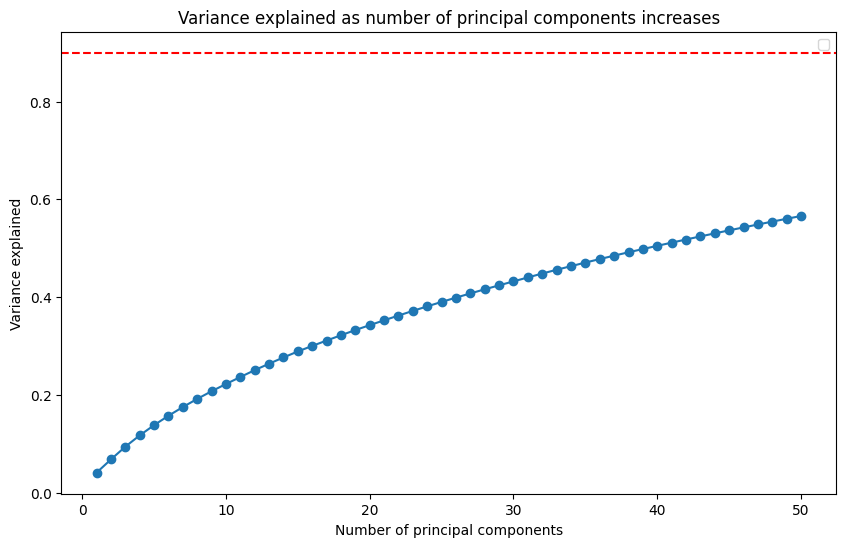

Creating opt PCA with n_components=40


(669, 40)

In [ ]:
reduced_batch_1_emb = opt_pca(batch_1_emb, verbose=True, n_comp=40)
reduced_batch_1_emb.shape

In [ ]:
#show dimensions of reduced_para_embedding

def show_2_dims(reduced_embedding):
  plt.scatter(reduced_embedding[:,0], reduced_embedding[:,1])
  plt.xlabel('dim_1')
  plt.ylabel('dim_2')
  plt.title('two dims of reduced embedding')

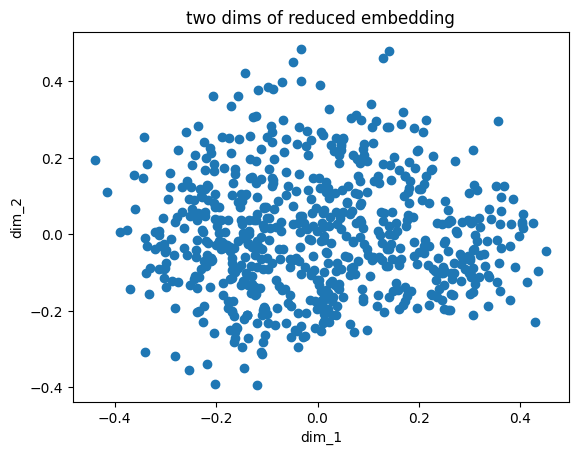

In [ ]:
#how about i don't do pca?
#show_2_dims(para_embeddings)
#plt.show()
show_2_dims(reduced_batch_1_emb)
plt.show()

<h1>hyperparameter tuning: need to find out optimum min num points for HDBSCAN</h3>

In [ ]:
#semantic analysis, need to come up with objective function for hyperparameter tuning for hdbscan
#weight this by num_points in cluster, otherwise the algo will favor small clusters

#clusterer is a hdbscan cluster object
#embeddings a matrix of example by reduced dimension, np array
def calc_semantic_sim(embeddings, cluster_labels):
  cluster_keys = np.unique(cluster_labels).tolist()
  if -1 in cluster_keys:
    cluster_keys.remove(-1) #remove noise key
  num_clusters = len(cluster_keys)
  num_clustered_points = (cluster_labels!=-1).sum()


  weighted_avg_sims = []

  for key in cluster_keys:
    ids = np.where(cluster_labels==key)[0]
    num_points = len(ids)
    cluster_embeddings = embeddings[ids]

    #calculate centroid
    cent = cluster_embeddings.mean(axis=0)

    cos_sims = []
    #for point in cluster, calc cos sim to centroid
    for id in ids:
      point = embeddings[id]
      cos_dist = distance.cosine(cent, point)
      cos_sims.append(1-cos_dist)

    #weight by num points in cluster
    avg_sim = np.mean(cos_sims)
    weight = num_points / num_clustered_points
    weighted_avg_sims.append(weight * avg_sim)

  return sum(weighted_avg_sims) #take sum not mean here

In [ ]:
def calc_semantic_sim_with_penalty(embeddings, cluster_labels, penalty_strength=1):
    cluster_keys = np.unique(cluster_labels).tolist()
    if -1 in cluster_keys:
        cluster_keys.remove(-1)  # remove noise key
    num_clusters = len(cluster_keys)
    num_points_total = len(cluster_labels)
    num_clustered_points = (cluster_labels != -1).sum()
    num_outliers = (cluster_labels == -1).sum()

    weighted_avg_sims = []

    for key in cluster_keys:
        ids = np.where(cluster_labels == key)[0]
        num_points = len(ids)
        cluster_embeddings = embeddings[ids]

        cent = cluster_embeddings.mean(axis=0)
        cos_sims = [1 - distance.cosine(cent, embeddings[i]) for i in ids]

        avg_sim = np.mean(cos_sims)
        weight = num_points / num_clustered_points
        weighted_avg_sims.append(weight * avg_sim)

    sim_score = sum(weighted_avg_sims)

    # Apply penalty for outliers
    outlier_ratio = num_outliers / num_points_total
    penalty = penalty_strength * outlier_ratio
    adjusted_score = sim_score * (1 - penalty)

    return adjusted_score


<h1>NB: calc_semantic_sim_with_penalty objective function here to tune min_cluster_size hyperparameter for HDBScan

In [ ]:
from scipy.spatial import distance
import numpy as np

def calc_semantic_sim_with_penalty(
    embeddings,
    cluster_labels,
    penalty_strength_outliers=0.5,
    penalty_strength_small_clusters=0.5,
    small_cluster_threshold=10
):
    cluster_keys = np.unique(cluster_labels).tolist()
    if -1 in cluster_keys:
        cluster_keys.remove(-1)  # remove noise key
    num_clusters = len(cluster_keys)
    num_points_total = len(cluster_labels)
    num_clustered_points = (cluster_labels != -1).sum()
    num_outliers = (cluster_labels == -1).sum()

    weighted_avg_sims = []
    small_cluster_penalty = 0

    for key in cluster_keys:
        ids = np.where(cluster_labels == key)[0]
        num_points = len(ids)
        cluster_embeddings = embeddings[ids]

        # Semantic similarity to centroid
        cent = cluster_embeddings.mean(axis=0)
        cos_sims = [1 - distance.cosine(cent, embeddings[i]) for i in ids]
        avg_sim = np.mean(cos_sims)

        # Weight by proportion of clustered points
        weight = num_points / num_clustered_points
        weighted_avg_sims.append(weight * avg_sim)

        # Penalize small clusters
        if num_points < small_cluster_threshold:
            small_cluster_penalty += (small_cluster_threshold - num_points) / small_cluster_threshold

    sim_score = sum(weighted_avg_sims)

    # Penalty terms
    outlier_ratio = num_outliers / num_points_total
    total_penalty = (
        penalty_strength_outliers * outlier_ratio +
        penalty_strength_small_clusters * (small_cluster_penalty / num_clusters if num_clusters > 0 else 0)
    )

    adjusted_score = sim_score * (1 - total_penalty)

    return adjusted_score

In [ ]:
#min_cluster_range as a list
def grid_search_hdb(min_cluster_range, embeddings):
  all_sims = []
  for min_points in min_cluster_range:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points)
    clusterer.fit(embeddings)
    cluster_labels = clusterer.labels_
    sim = calc_semantic_sim_with_penalty(embeddings, cluster_labels)
    all_sims.append(float(sim))
  return all_sims

In [ ]:
all_sims = grid_search_hdb([2,3,4,5,6,7,8], reduced_batch_1_emb)
all_sims

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[0.3253912472042961,
 0.3170313577772397,
 0.31222932772608025,
 0.35754584738266926,
 0.21576809617095039,
 0.28784289427959153,
 0.18760445380006685]

<h1> NB: 5 seems to be opt min num points for HDBscan

In [ ]:
#hdbscan clustering algo

def cluster_embeddings(min_cluster_size, reduced_embeddings):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
  clusterer.fit(reduced_embeddings)
  return clusterer

In [ ]:
clusterer = cluster_embeddings(5, reduced_batch_1_emb) #actually, min_cluster_size is a hyperparameter to tune
clusterer.labels_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5,  5, -1, -1, -1, -1,
       -1,  8, -1, -1,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5, -1,  6, -1,
       -1,  4,  6, -1, -1,  1, -1, -1,  2,  5, -1,  0,  6, -1,  3, -1,  2,
        2, -1, -1, -1, -1, -1, -1,  5,  4, -1, -1, -1, -1, -1, -1,  7, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  6, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  8,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1,  5,  1, -1, -1, -1,  8, -1, -1, -1, -1, -1, -1,  1,
       -1, -1,  8, -1, -1, -1, -1, -1,  0, -1, -1,  1, -1,  1, -1, -1, -1,
       -1,  8,  0, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1,  3, -1,
       -1, -1,  7, -1, -1, -1, -1,  5,  4, -1,  2, -1, -1,  7, -1, -1, -1,
       -1, -1, -1,  2, -1,  2, -1, -1,  6, -1, -1, -1,  5, -1, -1, -1, -1,
       -1, -1,  5, -1, -1

In [ ]:
import pandas as pd

temp_df = pd.DataFrame(clusterer.labels_)
temp_df.value_counts()

,count
0,
-1,569
6,18
5,15
2,15
1,11
7,9
8,9
4,9
0,8


In [ ]:
doc_clusters = create_doc_clusters(batch_1, clusterer.labels_)

In [ ]:
#create word_to_id, id_to_word, freq_mats (freq mats for each cluster based on global vocab)
word_to_id, id_to_word, freq_mats = create_vocab_and_matrices(batch_1, doc_clusters)

In [ ]:
#calculate tfifd and get words
for cluster_key, mat in freq_mats.items():
  ids, words = tfidf_selection(10, mat, id_to_word)
  print(f'cluster_key: {cluster_key}\nWords: {words}')

cluster_key: -1
Words: ['like', 'just', 'people', 'https', 'don', 'think', 'use', 'time', 'com', 'ai']
cluster_key: 0
Words: ['just', 'time', 'like', 'work', 'people', 'software', 'don', 'job', 'think', 'make']
cluster_key: 1
Words: ['firefox', 'mozilla', 'browser', 'like', 'just', 'don', 'web', 'https', 'chrome', 'data']
cluster_key: 2
Words: ['russia', 'ukraine', 'trump', 'war', 'just', 'nuclear', 'don', 'putin', 'people', 'like']
cluster_key: 3
Words: ['https', 'china', 'car', 'canada', 'cars', 'don', 'just', 'like', 'com', 'ev']
cluster_key: 4
Words: ['people', 'like', 'bitcoin', 'just', 'crypto', 'don', 'rich', 'government', 'gold', 'economy']
cluster_key: 5
Words: ['like', 'code', 'just', 'people', 'government', 'don', 'https', 'llm', 'discord', 'llms']
cluster_key: 6
Words: ['like', 'just', 'think', 'don', 'data', 'people', 'model', 'https', 'use', 'ai']
cluster_key: 7
Words: ['buffalo', 'blood', 'measles', 'child', 'just', 'luteolin', 'vaccines', 'like', 'people', 'https']
clus

Text(0.5, 1.0, 'clusters')

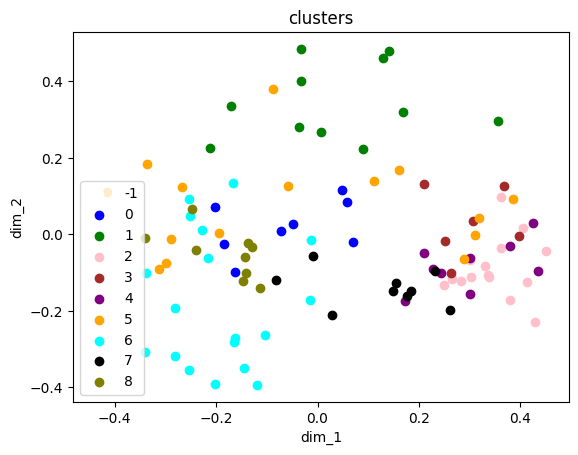

In [ ]:
#plot out 2 dims
clusters = np.unique(clusterer.labels_)
colors = ['white', 'blue', 'green', 'pink', 'brown', 'purple', 'orange', 'cyan', 'black', 'olive']

for cluster, color in zip(clusters, colors):
  doc_ids = np.where(clusterer.labels_==cluster)[0]
  cluster_mat = reduced_batch_1_emb[doc_ids]
  plt.scatter(cluster_mat[:,0], cluster_mat[:,1], color=color, label=cluster)

plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.legend()
plt.title('clusters')

<ipython-input-10-481a3b7934a6>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


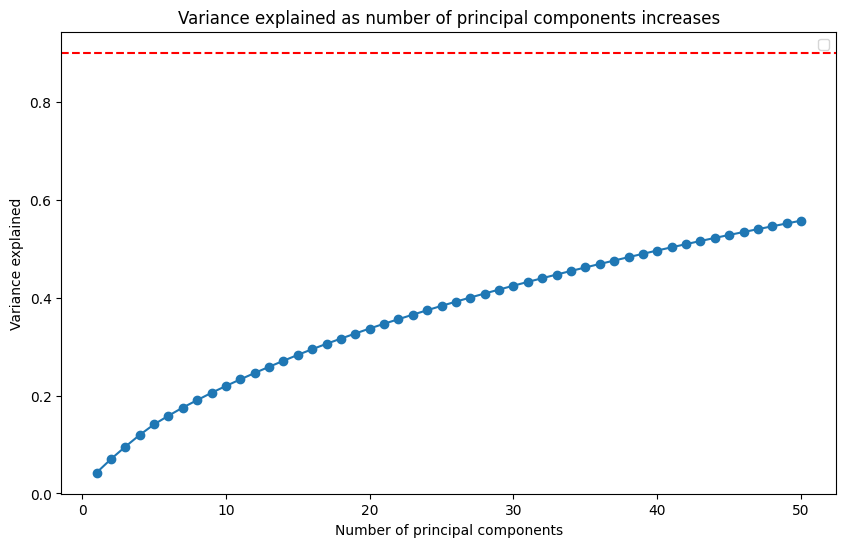

Creating opt PCA with n_components=40


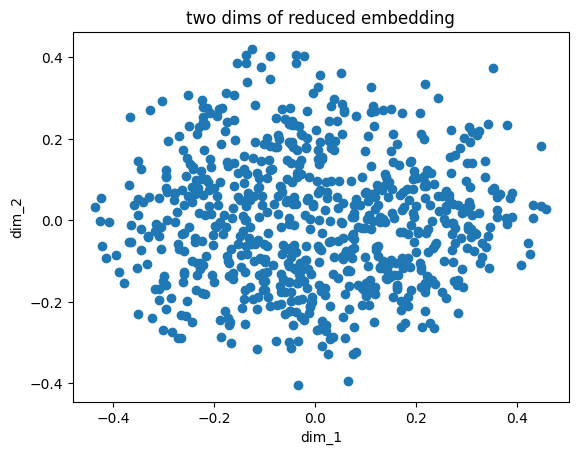

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[0.010369675535816006,
 0.28165828225808553,
 0.11099343540710072,
 0.3327556142364311,
 0.30917592181099784,
 0.3042364210213148,
 0.26623800672155473]

In [ ]:
#now do the same thing but with batch_2
reduced_batch_2_emb = opt_pca(batch_2_emb, verbose=True, n_comp=40) #standardize n_comp=40
show_2_dims(reduced_batch_2_emb)
plt.show() #show the scatter plot

#hyperparameter testing
batch_2_sims = grid_search_hdb([2,3,4,5,6,7,8], reduced_batch_2_emb)
batch_2_sims

In [ ]:
clusterer_2 = cluster_embeddings(5, reduced_batch_1_emb) #actually, min_cluster_size is a hyperparameter to tune
temp_df = pd.DataFrame(clusterer_2.labels_)
temp_df.value_counts()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,count
0,
-1,569
6,18
5,15
2,15
1,11
7,9
8,9
4,9
0,8


In [ ]:
doc_clusters_2 = create_doc_clusters(batch_2, clusterer_2.labels_)
word_to_id_2, id_to_word_2, freq_mats_2 = create_vocab_and_matrices(batch_2, doc_clusters_2)
for cluster_key, mat in freq_mats_2.items():
  ids, words = tfidf_selection(10, mat, id_to_word)
  print(f'cluster_key: {cluster_key}\nWords: {words}')

cluster_key: -1
Words: ['kata', 'intelligent_networkoh', 'olveralocation', 'harder', 'differentialequations', 'strapping', 'subjective', 'toll', 'clarifications', 'chooser']
cluster_key: 0
Words: ['addr_a', 'slime', 'chooser', 'kata', 'intelligent_networkoh', 'reproducibility', 'syndicating', 'groggy', 'budapest', 'tame']
cluster_key: 1
Words: ['anle', 'intelligent_networkoh', 'kata', 'olveralocation', 'toll', 'harder', 'differentialequations', 'signpost', 'strapping', 'nber']
cluster_key: 2
Words: ['intelligent_networkoh', 'kata', 'harder', 'bueno', 'differentialequations', 'olveralocation', 'clearcase', 'option3', 'alliance', 'clarifications']
cluster_key: 3
Words: ['olveralocation', 'strapping', 'catering', 'linguist', 'intelligent_networkoh', 'harder', 'postinghere', 'kata', 'causality', 'gru']
cluster_key: 4
Words: ['pharmaceutical', 'torpedos', 'kata', 'intelligent_networkoh', 'airfilters', 'olveralocation', 'differentialequations', 'strapping', 'cognitive_biashumans', 'sharedalb

In [ ]:
with open("cluster_0.txt", "w") as f:
  for item in doc_clusters[0]:
    f.write(item + "\n")

<h1>old stuff

In [ ]:
#old implementation
word_freq_mats = {}
vocabs = {}
word_to_id_dict = {}
id_to_word_dict = {}

for key, value in doc_clusters.items():
  #value is initially a ist of individual strings for each doc, need to convert to a single concat string (cluster_str_rep)
  cluster_str_rep = [" ".join(value)]
  word_freq_mats[key], vocabs[key], word_to_id_dict[key], id_to_word_dict[key] = create_vocab(cluster_str_rep)


In [ ]:
#old implementation
for key, value in doc_clusters.items():
  ids, words = tfidf_selection(10, word_freq_mats[key], id_to_word_dict[key])
  print(f'cluster_key: {key}\nWords: {words}')

#note that -1 is noise

cluster_key: -1
Words: ['like', 'just', 'people', 'don', 'https', 'think', 'time', 'use', 'com', 'way']
cluster_key: 0
Words: ['like', 'just', 'don', 'people', 'use', 'google', 'think', 'ai', 'time', 'search']
cluster_key: 1
Words: ['lisp', 'like', 'code', 'just', 'language', 'functional', 'use', 'languages', 'https', 'programming']


In [ ]:
#optimal min_cluster_size is 3
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
clusterer.fit(reduced_para_embeddings)
cluster_labels = clusterer.labels_

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
doc_clusters = create_doc_clusters(paras, clusterer.labels_)

In [ ]:
#create cluster_str_rep, a string representation of all the docs in a cluster, and all_docs
all_docs = []
for key, value in doc_clusters.items():
  cluster_str_rep = " ".join(value)
  all_docs.append(all_docs)

word_to_id, id_to_word, freq_mats = create_vocab_and_matrices(all_docs, doc_clusters.keys())

In [ ]:
#old implementation
word_freq_mats = {}
vocabs = {}
word_to_id_dict = {}
id_to_word_dict = {}

for key, value in doc_clusters.items():
  #value is initially a ist of individual strings for each doc, need to convert to a single concat string (cluster_str_rep)
  cluster_str_rep = [" ".join(value)]
  word_freq_mats[key], vocabs[key], word_to_id_dict[key], id_to_word_dict[key] = create_vocab(cluster_str_rep)


In [ ]:
#old implementation
for key, value in doc_clusters.items():
  ids, words = tfidf_selection(5, word_freq_mats[key], id_to_word_dict[key])
  print(f'cluster_key: {key}\nWords: {words}')

#note that -1 is noise

cluster_key: -1
Words: ['ai', 'sort', 'hirevue', 'matrix', 'explainability']
cluster_key: 0
Words: ['employee', 'model', 'employed', 'examples', 'agency']
cluster_key: 1
Words: ['responsibility', 'ai', 'agency', 'action', 'responsible']
cluster_key: 2
Words: ['privacy', 'right', 'moral', 'value', 'information']


In [ ]:
cluster_labels
#1, 4, 11, 12, 13 as the same essay on privacy rights
#3, 9, 10 as np.argsort
#2, 5, 6, 7, 8 as the same essay on responsibility
#14, 15, 16 as hirevue
#17, 18, 19, 20 as aml proj 1 report

array([ 2,  1, -1,  2,  1,  1,  1,  1, -1, -1,  2,  2,  2, -1, -1, -1,  0,
        0,  0,  0])

In [ ]:
type(paras)

list